<a href="https://colab.research.google.com/github/singhtejn/Stock_AI_ML/blob/main/FNN_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf

# Download historical data
stock_code = 'TATAMOTORS.NS'  # Example stock code (Apple Inc.)
df = yf.download(stock_code, start='2019-08-31', end='2024-07-31')

# Display the first few rows
print(df.head())

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-09-03  113.050003  115.349998  111.199997  112.650002  111.954514   
2019-09-04  112.000000  113.000000  106.000000  109.500000  108.823959   
2019-09-05  109.750000  119.349998  109.500000  118.050003  117.321175   
2019-09-06  118.349998  122.300003  116.550003  121.250000  120.501419   
2019-09-09  119.000000  122.599998  117.349998  121.900002  121.147400   

              Volume  
Date                  
2019-09-03  36905736  
2019-09-04  76317447  
2019-09-05  75789807  
2019-09-06  67761586  
2019-09-09  51297512  


In [ ]:
import numpy as np
import pandas as pd

# Calculate RSI (Relative Strength Index)
def calculate_rsi(df, period=14):
    delta = df['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi
    return df

# Calculate EMA (Exponential Moving Average)
def calculate_ema(df, period):
    df[f'EMA{period}'] = df['Close'].ewm(span=period, adjust=False).mean()
    return df

# Calculate MACD (Moving Average Convergence Divergence)
def calculate_macd(df):
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    return df

# Calculate Bollinger Bands
def calculate_bollinger_bands(df, period=20):
    df['SMA20'] = df['Close'].rolling(window=period).mean()
    df['Bollinger High'] = df['SMA20'] + 2 * df['Close'].rolling(window=period).std()
    df['Bollinger Low'] = df['SMA20'] - 2 * df['Close'].rolling(window=period).std()
    return df

# Calculate VWAP (Volume Weighted Average Price)
def calculate_vwap(df):
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
    return df

# Calculate Volume EMA
def calculate_volume_ema(df, period):
    df[f'Volume EMA{period}'] = df['Volume'].ewm(span=period, adjust=False).mean()
    return df

def calculate_atr(df, period=14):
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift(1))
    low_close = np.abs(df['Low'] - df['Close'].shift(1))
    tr = high_low.combine(high_close, max).combine(low_close, max)
    df['ATR'] = tr.rolling(window=period).mean()
    return df


# Compute all indicators
df = calculate_rsi(df)
df = calculate_ema(df, 20)
df = calculate_ema(df, 50)
df = calculate_ema(df, 100)
df = calculate_ema(df, 200)
df = calculate_macd(df)
df = calculate_bollinger_bands(df)
df = calculate_vwap(df)
df = calculate_volume_ema(df, 20)
df = calculate_volume_ema(df, 50)
df = calculate_atr(df)

# Drop rows with NaN values (due to indicators calculation)
df.dropna(inplace=True)

# Display the first few rows with indicators
print(df.head())


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-10-01  118.000000  119.849998  113.000000  115.300003  114.588158   
2019-10-03  112.650002  123.500000  112.650002  122.400002  121.644318   
2019-10-04  122.800003  123.800003  118.800003  119.650002  118.911293   
2019-10-07  120.250000  120.550003  116.349998  117.500000  116.774567   
2019-10-09  118.500000  121.699997  115.449997  120.900002  120.153572   

              Volume        RSI       EMA20       EMA50      EMA100  ...  \
Date                                                                 ...   
2019-10-01  40232789  32.409967  121.679227  118.527079  116.158141  ...   
2019-10-03  65103359  44.940750  121.747872  118.678958  116.281742  ...   
2019-10-04  35712218  41.160709  121.548075  118.717038  116.348440  ...   
2019-10-07  35471184  40.297194  121.162544  118.669311  116.371243  ...   
2019-10-09  44666296  48.

In [ ]:
def create_labels(df, percentage=10, days=30):
    df['Label'] = 'hold'

    for i in range(len(df) - days):
        current_price = df.iloc[i]['Close']
        future_prices = df.iloc[i + 1:i + days + 1]['Close']
        if len(future_prices) == days:
            future_max = future_prices.max()
            future_min = future_prices.min()

            if (future_max - current_price) / current_price >= percentage / 100:
                df.at[df.index[i], 'Label'] = 'buy'
            elif (future_min - current_price) / current_price <= -percentage / 100:
                df.at[df.index[i], 'Label'] = 'sell'

    return df

# Create labels
df = create_labels(df)

# Display the first few rows with labels
print(df.head())


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-10-01  118.000000  119.849998  113.000000  115.300003  114.588158   
2019-10-03  112.650002  123.500000  112.650002  122.400002  121.644318   
2019-10-04  122.800003  123.800003  118.800003  119.650002  118.911293   
2019-10-07  120.250000  120.550003  116.349998  117.500000  116.774567   
2019-10-09  118.500000  121.699997  115.449997  120.900002  120.153572   

              Volume        RSI       EMA20       EMA50      EMA100  ...  \
Date                                                                 ...   
2019-10-01  40232789  32.409967  121.679227  118.527079  116.158141  ...   
2019-10-03  65103359  44.940750  121.747872  118.678958  116.281742  ...   
2019-10-04  35712218  41.160709  121.548075  118.717038  116.348440  ...   
2019-10-07  35471184  40.297194  121.162544  118.669311  116.371243  ...   
2019-10-09  44666296  48.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Feature Engineering
features = [
    'Close', 'EMA20', 'EMA50', 'EMA100', 'EMA200', 'RSI', 'MACD', 'MACD Signal',
    'Bollinger High', 'Bollinger Low', 'VWAP', 'Volume EMA20', 'Volume EMA50', 'ATR'
]
X = df[features]
y = df['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a supervised learning model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         buy       0.94      0.96      0.95       113
        hold       0.92      0.88      0.90        69
        sell       0.97      0.98      0.97        57

    accuracy                           0.94       239
   macro avg       0.94      0.94      0.94       239
weighted avg       0.94      0.94      0.94       239



In [ ]:
import yfinance as yf
import pandas as pd

# List of tickers
tickers = ['ADANIENT.NS', 'RELIANCE.NS', 'TATAMOTORS.NS']  # Add more tickers as needed

def fetch_data(tickers, start, end):
    dfs = []
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end)
        df['Ticker'] = ticker
        dfs.append(df)
    return pd.concat(dfs)

# Download historical stock data
df = fetch_data(tickers, start='2019-08-01', end='2024-07-31')

# Reset index to make 'Date' a column
df.reset_index(inplace=True)

# Display initial DataFrame structure
print("Columns in DataFrame:", df.columns)
print("First few rows of the DataFrame:\n", df.head())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Columns in DataFrame: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Ticker'],
      dtype='object')
First few rows of the DataFrame:
         Date        Open        High         Low       Close   Adj Close  \
0 2019-08-01  128.600006  129.100006  123.000000  125.449997  124.229042   
1 2019-08-02  124.900002  129.750000  123.300003  128.100006  126.853264   
2 2019-08-05  126.199997  126.400002  121.150002  124.699997  123.486343   
3 2019-08-06  124.000000  129.449997  124.000000  128.199997  126.952286   
4 2019-08-07  128.199997  130.149994  124.599998  125.599998  124.377579   

    Volume       Ticker  
0  4462938  ADANIENT.NS  
1  4637509  ADANIENT.NS  
2  5259236  ADANIENT.NS  
3  3899290  ADANIENT.NS  
4  3911797  ADANIENT.NS  


In [ ]:
# Drop 'Adj Close' column if it exists
if 'Adj Close' in df.columns:
    df.drop(columns=['Adj Close'], inplace=True)

# Create labels based on future price movement
df['Label'] = 'hold'
df['Future Close'] = df.groupby('Ticker')['Close'].shift(-30)
df['Pct Change'] = (df['Future Close'] - df['Close']) / df['Close']
df.loc[df['Pct Change'] >= 0.20, 'Label'] = 'buy'
df.loc[df['Pct Change'] <= -0.10, 'Label'] = 'sell'
df.drop(['Future Close', 'Pct Change'], axis=1, inplace=True)

# Encode labels
label_mapping = {'buy': 0, 'hold': 1, 'sell': 2}
df['Label'] = df['Label'].map(label_mapping)

# Remove NaN values
df.dropna(inplace=True)

# Display DataFrame after preparation
print("Columns in DataFrame after preparation:", df.columns)
print("First few rows of the DataFrame after preparation:\n", df.head())


Columns in DataFrame after preparation: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'Label'], dtype='object')
First few rows of the DataFrame after preparation:
         Date        Open        High         Low       Close   Volume  \
0 2019-08-01  128.600006  129.100006  123.000000  125.449997  4462938   
1 2019-08-02  124.900002  129.750000  123.300003  128.100006  4637509   
2 2019-08-05  126.199997  126.400002  121.150002  124.699997  5259236   
3 2019-08-06  124.000000  129.449997  124.000000  128.199997  3899290   
4 2019-08-07  128.199997  130.149994  124.599998  125.599998  3911797   

        Ticker  Label  
0  ADANIENT.NS      1  
1  ADANIENT.NS      1  
2  ADANIENT.NS      1  
3  ADANIENT.NS      1  
4  ADANIENT.NS      1  


In [ ]:
import yfinance as yf
import pandas as pd

def fetch_data(tickers, start, end):
    dfs = []
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end)
        df['Ticker'] = ticker
        df.reset_index(inplace=True)  # Ensure 'Date' is a column
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)  # Concatenate and reset index

def calculate_ema(df, column, period):
    """ Calculate Exponential Moving Average (EMA) """
    if 'Date' in df.columns:
        df = df.sort_values(by='Date').drop_duplicates(subset=['Date'])  # Sort and drop duplicates
    return df[column].ewm(span=period, adjust=False).mean()

def calculate_macd(df):
    """ Calculate MACD and MACD Signal """
    if 'Date' in df.columns:
        df = df.sort_values(by='Date').drop_duplicates(subset=['Date'])
    df['EMA12'] = calculate_ema(df, 'Close', 12)
    df['EMA26'] = calculate_ema(df, 'Close', 26)
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD Signal'] = calculate_ema(df, 'MACD', 9)
    return df

def calculate_bollinger_bands(df, column, window=20, num_sd=2):
    """ Calculate Bollinger Bands """
    if 'Date' in df.columns:
        df = df.sort_values(by='Date').drop_duplicates(subset=['Date'])
    rolling_mean = df[column].rolling(window=window).mean()
    rolling_std = df[column].rolling(window=window).std()
    df['Bollinger High'] = rolling_mean + (rolling_std * num_sd)
    df['Bollinger Low'] = rolling_mean - (rolling_std * num_sd)
    return df

# Define tickers
tickers = ['ADANIENT.NS', 'RELIANCE.NS', 'TATAMOTORS.NS']

# Download historical stock data
df = fetch_data(tickers, start='2019-08-01', end='2024-07-31')

# Drop 'Adj Close' if exists
if 'Adj Close' in df.columns:
    df.drop(columns=['Adj Close'], inplace=True)

# Drop duplicates based on Date and reset index
if 'Date' in df.columns:
    df = df.drop_duplicates(subset=['Date']).reset_index(drop=True)
else:
    print("Date column is missing in the DataFrame.")

# Add technical indicators
df['EMA20'] = calculate_ema(df, 'Close', 20)
df['EMA50'] = calculate_ema(df, 'Close', 50)
df['EMA100'] = calculate_ema(df, 'Close', 100)
df['EMA200'] = calculate_ema(df, 'Close', 200)
df = calculate_macd(df)
df = calculate_bollinger_bands(df, 'Close')

# Display DataFrame with new columns
print(df[['Date', 'Close', 'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'MACD Signal', 'Bollinger High', 'Bollinger Low']].head())

# Drop 'Adj Close' column if it exists
if 'Adj Close' in df.columns:
    df.drop(columns=['Adj Close'], inplace=True)

# Create labels based on future price movement
df['Label'] = 'hold'
df['Future Close'] = df.groupby('Ticker')['Close'].shift(-30)
df['Pct Change'] = (df['Future Close'] - df['Close']) / df['Close']
df.loc[df['Pct Change'] >= 0.20, 'Label'] = 'buy'
df.loc[df['Pct Change'] <= -0.10, 'Label'] = 'sell'
df.drop(['Future Close', 'Pct Change'], axis=1, inplace=True)

# Encode labels
label_mapping = {'buy': 0, 'hold': 1, 'sell': 2}
df['Label'] = df['Label'].map(label_mapping)

# Remove NaN values
df.dropna(inplace=True)

# Display DataFrame after preparation
print("Columns in DataFrame after preparation:", df.columns)
print("First few rows of the DataFrame after preparation:\n", df.head())



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


        Date       Close       EMA20       EMA50      EMA100      EMA200  \
0 2019-08-01  125.449997  125.449997  125.449997  125.449997  125.449997   
1 2019-08-02  128.100006  125.702379  125.553919  125.502472  125.476365   
2 2019-08-05  124.699997  125.606914  125.520432  125.486582  125.468640   
3 2019-08-06  128.199997  125.853874  125.625513  125.540313  125.495818   
4 2019-08-07  125.599998  125.829695  125.624512  125.541495  125.496854   

       MACD  MACD Signal  Bollinger High  Bollinger Low  
0  0.000000     0.000000             NaN            NaN  
1  0.211397     0.042279             NaN            NaN  
2  0.103386     0.054501             NaN            NaN  
3  0.296786     0.102958             NaN            NaN  
4  0.237521     0.129871             NaN            NaN  
Columns in DataFrame after preparation: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'EMA20',
       'EMA50', 'EMA100', 'EMA200', 'EMA12', 'EMA26', 'MACD', 'MACD Signal',
  

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3483 - loss: 1.0984 - val_accuracy: 0.3507 - val_loss: 1.0970
Epoch 2/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3593 - loss: 1.0964 - val_accuracy: 0.3552 - val_loss: 1.0958
Epoch 3/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3591 - loss: 1.0963 - val_accuracy: 0.3629 - val_loss: 1.0958
Epoch 4/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3625 - loss: 1.0961 - val_accuracy: 0.3627 - val_loss: 1.0954
Epoch 5/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3600 - loss: 1.0960 - val_accuracy: 0.3686 - val_loss: 1.0954
Epoch 6/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.3603 - loss: 1.0957 - val_accuracy: 0.3721 - val_loss: 1.0948
Epoch 7/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3630 - loss: 1.0949 - val_accuracy: 0.3688 - val_loss: 1.0945
Epoch 8/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.3669 - loss: 1.0955 - val_accurac

              precision    recall  f1-score   support

           0       0.37      0.73      0.49      4198
           1       0.36      0.35      0.35      3887
           2       0.43      0.02      0.03      4055

    accuracy                           0.37     12140
   macro avg       0.39      0.36      0.29     12140
weighted avg       0.39      0.37      0.29     12140



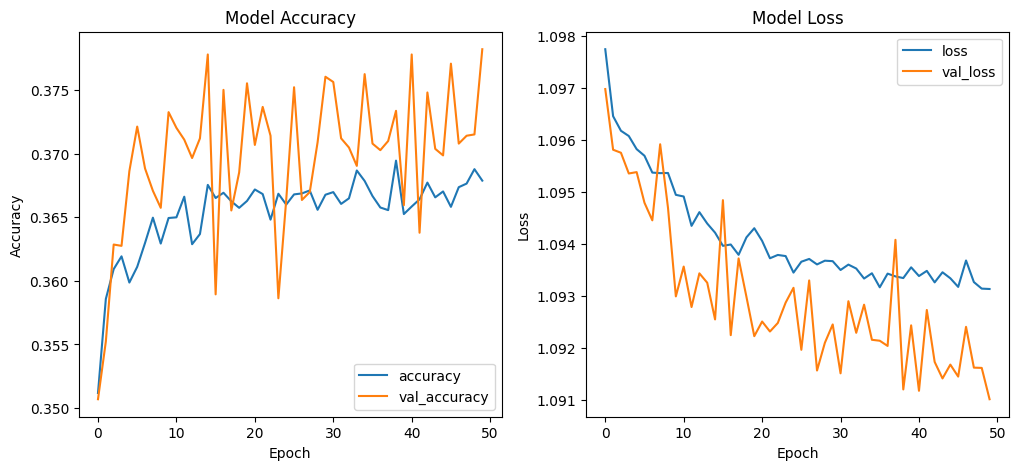

In [ ]:
#!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def fetch_data(tickers, start, end):
    dfs = []
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end)
        df['Ticker'] = ticker
        df.reset_index(inplace=True)  # Ensure 'Date' is a column
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)  # Concatenate and reset index

def calculate_ema(df, column, period):
    return df[column].ewm(span=period, adjust=False).mean()

def calculate_macd(df):
    df['EMA12'] = calculate_ema(df, 'Close', 12)
    df['EMA26'] = calculate_ema(df, 'Close', 26)
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD Signal'] = calculate_ema(df, 'MACD', 9)
    return df

def calculate_bollinger_bands(df, column, window=20, num_sd=2):
    rolling_mean = df[column].rolling(window=window).mean()
    rolling_std = df[column].rolling(window=window).std()
    df['Bollinger High'] = rolling_mean + (rolling_std * num_sd)
    df['Bollinger Low'] = rolling_mean - (rolling_std * num_sd)
    return df

def apply_indicators(df):
    grouped = df.groupby('Ticker')

    def apply_group(group):
        group = group.sort_values(by='Date').drop_duplicates(subset=['Date'])
        group['EMA20'] = calculate_ema(group, 'Close', 20)
        group['EMA50'] = calculate_ema(group, 'Close', 50)
        group['EMA100'] = calculate_ema(group, 'Close', 100)
        group['EMA200'] = calculate_ema(group, 'Close', 200)
        group = calculate_macd(group)
        group = calculate_bollinger_bands(group, 'Close')
        return group

    result_df = grouped.apply(apply_group).reset_index(drop=True)
    return result_df

def create_labels(df):
    """ Create labels based on future returns.
        threshold: percentage change threshold to classify as buy/sell/hold
    """
    df['Future Close'] = df.groupby('Ticker')['Close'].shift(-5)
    df['Return'] = (df['Future Close'] - df['Close']) / df['Close']

    conditions = [
        (df['Return'] > 0.02),   # Buy
        (df['Return'] < -0.01),  # Sell
    ]
    choices = [1, 2]  # Labels: 1 for Buy, 2 for Sell

    df['Label'] = np.select(conditions, choices, default=0)  # 0 for Hold
    df.drop(columns=['Future Close', 'Return'], inplace=True)
    return df

def preprocess_data(df):
    df = create_labels(df)

    # Drop non-numeric columns for feature scaling
    df.drop(columns=['Date', 'Ticker'], inplace=True)

    # Drop any rows with NaN values
    df.dropna(inplace=True)

    return df

# Define tickers
tickers = ['DRREDDY.NS', 'HINDALCO.NS', 'JSWSTEEL.NS', 'TATAMOTORS.NS', 'M&M.NS', 'ONGC.NS', 'COALINDIA.NS', 'TECHM.NS', 'UPL.NS', 'TATASTEEL.NS',
           'TATACONSUM.NS', 'ITC.NS', 'ADANIENT.NS', 'TITAN.NS', 'EICHERMOT.NS', 'ADANIPORTS.NS', 'RELIANCE.NS', 'BPCL.NS', 'LT.NS', 'NTPC.NS',
           'LTIM.NS', 'BAJAJ-AUTO.NS', 'SUNPHARMA.NS', 'INFY.NS', 'WIPRO.NS', 'INDUSINDBK.NS', 'HCLTECH.NS', 'SBIN.NS', 'KOTAKBANK.NS', 'HDFCLIFE.NS',
           'BAJAJFINSV.NS', 'SBILIFE.NS', 'BRITANNIA.NS', 'HDFCBANK.NS', 'CIPLA.NS', 'GRASIM.NS', 'NESTLEIND.NS', 'BHARTIARTL.NS', 'TCS.NS',
           'AXISBANK.NS', 'HEROMOTOCO.NS', 'HINDUNILVR.NS', 'ASIANPAINT.NS', 'POWERGRID.NS', 'ULTRACEMCO.NS', 'ICICIBANK.NS', 'APOLLOHOSP.NS',
           'MARUTI.NS', 'BAJFINANCE.NS', 'DIVISLAB.NS']

# Download historical stock data
df = fetch_data(tickers, start='2019-08-01', end='2024-07-31')

# Apply indicators
df = apply_indicators(df)

# Preprocess data
df = preprocess_data(df)

# Prepare data for training
X = df[['Open', 'High', 'Low', 'Close', 'Volume', 'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'MACD Signal', 'Bollinger High', 'Bollinger Low']]
y = df['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 classes: buy, hold, sell

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
print(classification_report(y_test, y_pred))

# Save the model
model.save('stock_prediction_model.h5')

# Load the model for future use
# model = tf.keras.models.load_model('stock_prediction_model.h5')

# Print the history of the model training
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

[[0.08323294 0.08162318 0.08256794 ... 0.6322107  0.08226247 0.08361334]
 [0.0415652  0.04209743 0.0418552  ... 0.63051452 0.04211094 0.04068229]
 [0.01029838 0.01007406 0.01026028 ... 0.62207229 0.00959103 0.00891413]
 ...
 [0.04098203 0.04258576 0.04148077 ... 0.6257772  0.04218606 0.03903647]
 [0.16013497 0.15679306 0.16081777 ... 0.64505544 0.15710331 0.16396736]
 [0.04064239 0.03983106 0.04023479 ... 0.63362109 0.04343919 0.0385148 ]]
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


474/474 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4944 - loss: 1.0464 - val_accuracy: 0.4955 - val_loss: 1.0364
Epoch 2/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5008 - loss: 1.0367 - val_accuracy: 0.4960 - val_loss: 1.0389
Epoch 3/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5023 - loss: 1.0335 - val_accuracy: 0.4955 - val_loss: 1.0336
Epoch 4/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4996 - loss: 1.0355 - val_accuracy: 0.4955 - val_loss: 1.0334
Epoch 5/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5015 - loss: 1.0338 - val_accuracy: 0.4955 - val_loss: 1.0322
Epoch 6/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4995 - loss: 1.0334 - val_accuracy: 0.4955 - val_loss: 1.0330
Epoch 7/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4997 - loss: 1.0337 - val_accuracy: 0.4955 - val_loss: 1.0322
Epoch 8/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4927 - loss: 1.0369 - val_accuracy: 0.4971 - val_

              precision    recall  f1-score   support

           0       0.50      0.98      0.66      2324
           1       0.44      0.07      0.13      1138
           2       0.38      0.01      0.02      1278

    accuracy                           0.50      4740
   macro avg       0.44      0.35      0.27      4740
weighted avg       0.45      0.50      0.36      4740



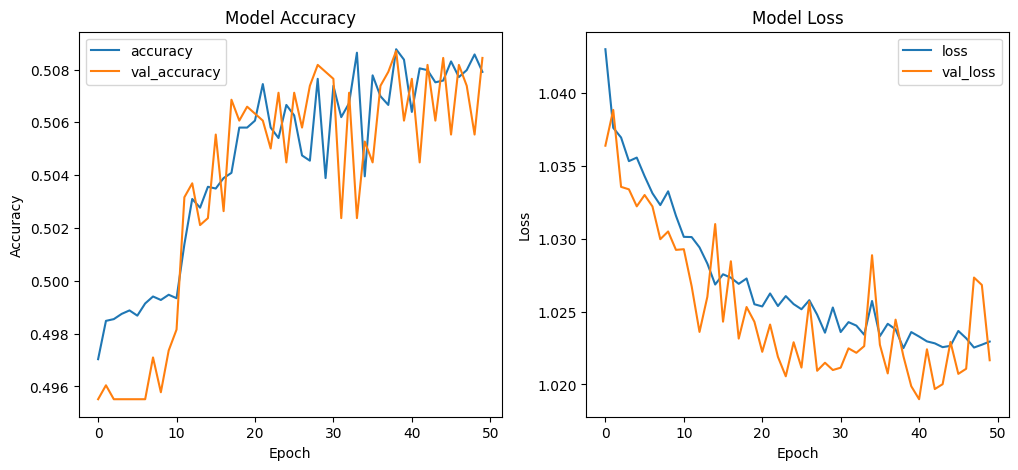

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def fetch_data(tickers, start, end):
    dfs = []
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end)
        df['Ticker'] = ticker
        df.reset_index(inplace=True)  # Ensure 'Date' is a column
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)  # Concatenate and reset index

def calculate_ema(df, column, period):
    return df[column].ewm(span=period, adjust=False).mean()

def calculate_macd(df):
    df['EMA12'] = calculate_ema(df, 'Close', 12)
    df['EMA26'] = calculate_ema(df, 'Close', 26)
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD Signal'] = calculate_ema(df, 'MACD', 9)
    return df

def calculate_bollinger_bands(df, column, window=20, num_sd=2):
    rolling_mean = df[column].rolling(window=window).mean()
    rolling_std = df[column].rolling(window=window).std()
    df['Bollinger High'] = rolling_mean + (rolling_std * num_sd)
    df['Bollinger Low'] = rolling_mean - (rolling_std * num_sd)
    return df

def apply_indicators(df):
    grouped = df.groupby('Ticker')

    def apply_group(group):
        group = group.sort_values(by='Date').drop_duplicates(subset=['Date'])
        group['EMA20'] = calculate_ema(group, 'Close', 20)
        group['EMA50'] = calculate_ema(group, 'Close', 50)
        group['EMA100'] = calculate_ema(group, 'Close', 100)
        group['EMA200'] = calculate_ema(group, 'Close', 200)
        group = calculate_macd(group)
        group = calculate_bollinger_bands(group, 'Close')
        return group

    result_df = grouped.apply(apply_group).reset_index(drop=True)
    return result_df

def create_labels(df):
    """ Create labels based on future returns.
        threshold: percentage change threshold to classify as buy/sell/hold
    """
    df['Future Close'] = df.groupby('Ticker')['Close'].shift(-10)
    df['Return'] = (df['Future Close'] - df['Close']) / df['Close']

    conditions = [
        (df['Return'] > 0.05),   # Buy
        (df['Return'] < -0.025),  # Sell
    ]
    choices = [1, 2]  # Labels: 1 for Buy, 2 for Sell

    df['Label'] = np.select(conditions, choices, default=0)  # 0 for Hold
    df.drop(columns=['Future Close', 'Return'], inplace=True)
    return df

def preprocess_data(df):
    # Drop any rows with NaN values
    df.dropna(inplace=True)

    df = create_labels(df)

    # Drop non-numeric columns for feature scaling
    df.drop(columns=['Date', 'Ticker'], inplace=True)

    # Drop any rows with NaN values
    df.dropna(inplace=True)

    return df

# Define tickers
tickers = ['DRREDDY.NS', 'HINDALCO.NS', 'JSWSTEEL.NS', 'TATAMOTORS.NS', 'M&M.NS', 'ONGC.NS', 'COALINDIA.NS', 'TECHM.NS', 'UPL.NS', 'TATASTEEL.NS',
           'TATACONSUM.NS', 'ITC.NS', 'ADANIENT.NS', 'TITAN.NS', 'EICHERMOT.NS', 'ADANIPORTS.NS', 'RELIANCE.NS', 'BPCL.NS', 'LT.NS', 'NTPC.NS',
           'LTIM.NS', 'BAJAJ-AUTO.NS', 'SUNPHARMA.NS', 'INFY.NS', 'WIPRO.NS', 'INDUSINDBK.NS', 'HCLTECH.NS', 'SBIN.NS', 'KOTAKBANK.NS', 'HDFCLIFE.NS',
           'BAJAJFINSV.NS', 'SBILIFE.NS', 'BRITANNIA.NS', 'HDFCBANK.NS', 'CIPLA.NS', 'GRASIM.NS', 'NESTLEIND.NS', 'BHARTIARTL.NS', 'TCS.NS',
           'AXISBANK.NS', 'HEROMOTOCO.NS', 'HINDUNILVR.NS', 'ASIANPAINT.NS', 'POWERGRID.NS', 'ULTRACEMCO.NS', 'ICICIBANK.NS', 'APOLLOHOSP.NS',
           'MARUTI.NS', 'BAJFINANCE.NS', 'DIVISLAB.NS']

# Download historical stock data
df = fetch_data(tickers, start='2019-01-01', end='2020-12-31')

# Apply indicators
df = apply_indicators(df)

# Preprocess data
df = preprocess_data(df)

# Prepare data for training
X = df[['Open', 'High', 'Low', 'Close', 'Volume', 'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'MACD Signal', 'Bollinger High', 'Bollinger Low']]
y = df['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled)

# Build the neural network model
model = Sequential()
model.add(Dense(128, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 classes: buy, hold, sell

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
print(classification_report(y_test, y_pred))

# Save the model
model.save('stock_prediction_model.h5')

# Load the model for future use
# model = tf.keras.models.load_model('stock_prediction_model.h5')

# Print the history of the model training
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Class Weights: {0: 0.7522733962293381, 1: 1.0369421311125346, 2: 1.4157847167555906}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3487 - loss: 1.0982 - val_accuracy: 0.4067 - val_loss: 1.0966
Epoch 2/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3900 - loss: 1.0963 - val_accuracy: 0.4407 - val_loss: 1.0903
Epoch 3/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4086 - loss: 1.0959 - val_accuracy: 0.3752 - val_loss: 1.1032
Epoch 4/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4119 - loss: 1.0953 - val_accuracy: 0.4210 - val_loss: 1.0945
Epoch 5/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4184 - loss: 1.0944 - val_accuracy: 0.4415 - val_loss: 1.0890
Epoch 6/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4239 - loss: 1.0950 - val_accuracy: 0.4076 - val_loss: 1.0962
Epoch 7/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4112 - loss: 1.0965 - val_accuracy: 0.4239 - val_loss: 1.0965
Epoch 8/100
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4246 - loss: 1

              precision    recall  f1-score   support

           0       0.48      0.57      0.52      5375
           1       0.36      0.22      0.28      3887
           2       0.27      0.31      0.29      2878

    accuracy                           0.40     12140
   macro avg       0.37      0.37      0.36     12140
weighted avg       0.39      0.40      0.39     12140

Accuracy: 0.3974464579901153


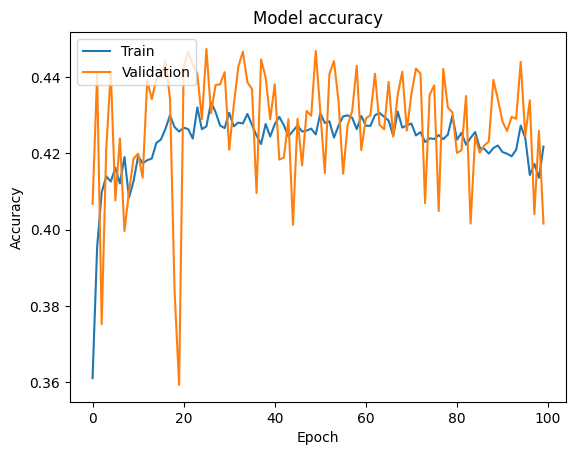

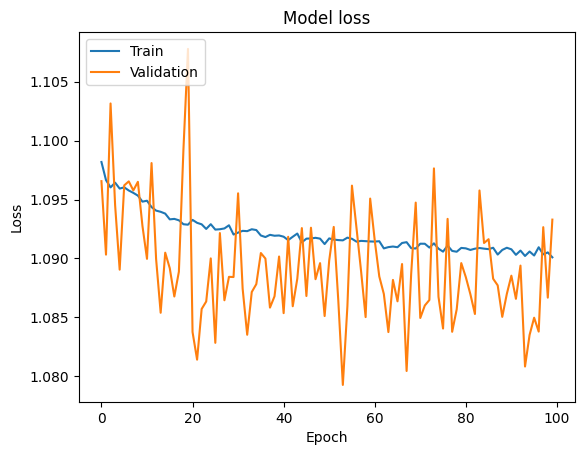

In [31]:
# Install necessary packages (commented out as it's typically done in a setup phase, not in the script)
# !pip install keras
# !pip install --upgrade tensorflow
# !pip install tensorflow scikit-learn

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from tensorflow.keras.optimizers import Adam
import numpy as np
import yfinance as yf
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# Fetch historical OHLCV data for given stock tickers
def fetch_data(tickers, start, end):
    dfs = []
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end)  # Download data from Yahoo Finance
        df['Ticker'] = ticker  # Add ticker as a column
        df.reset_index(inplace=True)  # Ensure 'Date' is a column
        dfs.append(df)  # Append dataframe to the list
    return pd.concat(dfs, ignore_index=True)  # Concatenate all dataframes and reset index

# Calculate Exponential Moving Average (EMA)
def calculate_ema(df, column, period):
    return df[column].ewm(span=period, adjust=False).mean()

# Calculate MACD and MACD Signal
def calculate_macd(df):
    df['EMA12'] = calculate_ema(df, 'Close', 12)
    df['EMA26'] = calculate_ema(df, 'Close', 26)
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD Signal'] = calculate_ema(df, 'MACD', 9)
    return df

#Calculate Bollinger Bands
def calculate_bollinger_bands(df, column, window=20, num_sd=2):
    rolling_mean = df[column].rolling(window=window).mean()
    rolling_std = df[column].rolling(window=window).std()
    df['Bollinger High'] = rolling_mean + (rolling_std * num_sd)
    df['Bollinger Low'] = rolling_mean - (rolling_std * num_sd)
    return df

# Calculate VWAP (Volume Weighted Average Price)
def calculate_vwap(df):
    df['Cumulative_Price_Volume'] = (df['Close'] * df['Volume']).cumsum()
    df['Cumulative_Volume'] = df['Volume'].cumsum()
    df['VWAP'] = df['Cumulative_Price_Volume'] / df['Cumulative_Volume']
    return df

# Calculate Relative Strength Index (RSI)
def calculate_rsi(df, column, period=14):
    delta = df[column].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

# Apply technical indicators to DataFrame ticker-wise
def apply_indicators(df):
    grouped = df.groupby('Ticker')  # Group data by ticker

    def apply_group(group):
        group = group.sort_values(by='Date').drop_duplicates(subset=['Date'])  # Ensure no duplicate dates
        group['EMA20'] = calculate_ema(group, 'Close', 20)
        group['EMA50'] = calculate_ema(group, 'Close', 50)
        group['EMA100'] = calculate_ema(group, 'Close', 100)
        group = calculate_macd(group)
        group = calculate_bollinger_bands(group, 'Close')
        group = calculate_vwap(group)
        group = calculate_rsi(group, 'Close')
        return group

    result_df = grouped.apply(apply_group).reset_index(drop=True)  # Apply to each group and reset index
    return result_df

# Create labels for the classification task
def create_labels(df):
    df['Buy'] = (df['RSI'] > 65) & (df['RSI'].diff() > 0)
    df['Sell'] = (df['RSI'] < 35) & (df['RSI'].diff() < 0)
    df['Label'] = np.where(df['Buy'], 1, np.where(df['Sell'], 2, 0))  # Label encoding: Buy=1, Sell=2, Hold=0
    return df

# Preprocess data: label creation and scaling
def preprocess_data(df):

    # Create labels
    df = create_labels(df)

    # Drop non-numeric columns for feature scaling
    df.drop(columns=['Date', 'Ticker'], inplace=True)

    # Drop any rows with NaN values
    df.dropna(inplace=True)

    return df

def main():
    # Define tickers
    tickers = ['DRREDDY.NS', 'HINDALCO.NS', 'JSWSTEEL.NS', 'TATAMOTORS.NS', 'M&M.NS', 'ONGC.NS', 'COALINDIA.NS', 'TECHM.NS', 'UPL.NS', 'TATASTEEL.NS',
               'TATACONSUM.NS', 'ITC.NS', 'ADANIENT.NS', 'TITAN.NS', 'EICHERMOT.NS', 'ADANIPORTS.NS', 'RELIANCE.NS', 'BPCL.NS', 'LT.NS', 'NTPC.NS',
               'LTIM.NS', 'BAJAJ-AUTO.NS', 'SUNPHARMA.NS', 'INFY.NS', 'WIPRO.NS', 'INDUSINDBK.NS', 'HCLTECH.NS', 'SBIN.NS', 'KOTAKBANK.NS', 'HDFCLIFE.NS',
               'BAJAJFINSV.NS', 'SBILIFE.NS', 'BRITANNIA.NS', 'HDFCBANK.NS', 'CIPLA.NS', 'GRASIM.NS', 'NESTLEIND.NS', 'BHARTIARTL.NS', 'TCS.NS',
               'AXISBANK.NS', 'HEROMOTOCO.NS', 'HINDUNILVR.NS', 'ASIANPAINT.NS', 'POWERGRID.NS', 'ULTRACEMCO.NS', 'ICICIBANK.NS', 'APOLLOHOSP.NS',
               'MARUTI.NS', 'BAJFINANCE.NS', 'DIVISLAB.NS']

    # Download historical stock data
    start_date = '2019-08-01'
    end_date = '2024-07-31'
    df = fetch_data(tickers, start=start_date, end=end_date)

    # Apply technical indicators
    df = apply_indicators(df)

    # Preprocess data
    df = preprocess_data(df)

    # Define features and labels
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA20', 'EMA50', 'EMA100', 'MACD', 'MACD Signal', 'Bollinger High', 'Bollinger Low', 'VWAP', 'RSI']
    X = df[features]
    y = df['Label']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Class weights calculation
    y_train = np.array(y_train)

    # Compute class counts
    class_counts = pd.Series(y_train).value_counts()
    # Compute total number of samples
    total_samples = len(y_train)
    # Compute the number of classes
    num_classes = len(class_counts)
    # Compute class weights
    class_weights = {}
    for cls, count in class_counts.items():
        weight = total_samples / (num_classes * count)
        class_weights[cls] = weight

    # Print the computed class weights
    print("Class Weights:", class_weights)

    # Build the model
    best_params = {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'optimizer': 'adam', 'units1': 64, 'units2': 32}

    # Extract parameters
    units1 = best_params['units1']
    units2 = best_params['units2']
    dropout_rate = best_params['dropout_rate']
    optimizer_name = best_params['optimizer']

    # Initialize optimizer based on best hyperparameters
    if optimizer_name == 'adam':
        optimizer = Adam()
    elif optimizer_name == 'sgd':
        from tensorflow.keras.optimizers import SGD
        optimizer = SGD()
    else:
        # Handle other optimizers if needed
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    # Initialize the model with best hyperparameters
    model = Sequential()
    model.add(Dense(units=units1, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=units2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # 3 classes: buy, hold, sell

    # Compile the model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model with class weights
    history = model.fit(X_train_scaled, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_split=0.2, class_weight=class_weights)

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)

    # Ensure y_pred is 2D (num_samples, num_classes)
    if y_pred.ndim == 1:
        y_pred_classes = y_pred  # If predictions are already class labels
    else:
        y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

    # Print classification report
    print(classification_report(y_test, y_pred_classes))

    # Print accuracy score
    print(f"Accuracy: {accuracy_score(y_test, y_pred_classes)}")

    # Save the model
    model.save('/content/drive/MyDrive/Colab Notebooks/ML Models/stock_trading_model.h5')

    # Save the scaler
    joblib.dump(scaler, '/content/drive/MyDrive/Colab Notebooks/ML Models/scaler.save')

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

if __name__ == "__main__":
    main()


[*********************100%%**********************]  1 of 1 completed


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Columns after prediction: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker',
       'EMA20', 'EMA50', 'EMA100', 'EMA12', 'EMA26', 'MACD', 'MACD Signal',
       'SMA20', 'Bollinger High', 'Bollinger Low', 'VWAP', 'RSI', 'Buy',
       'Sell', 'Label', 'Predicted Label'],
      dtype='object')
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       958
           1       0.57      1.00      0.73       177
           2       0.57      1.00      0.73        59

    accuracy                           0.85      1194
   macro avg       0.72      0.94      0.79      1194
weighted avg       0.92      0.85      0.87      1194

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━

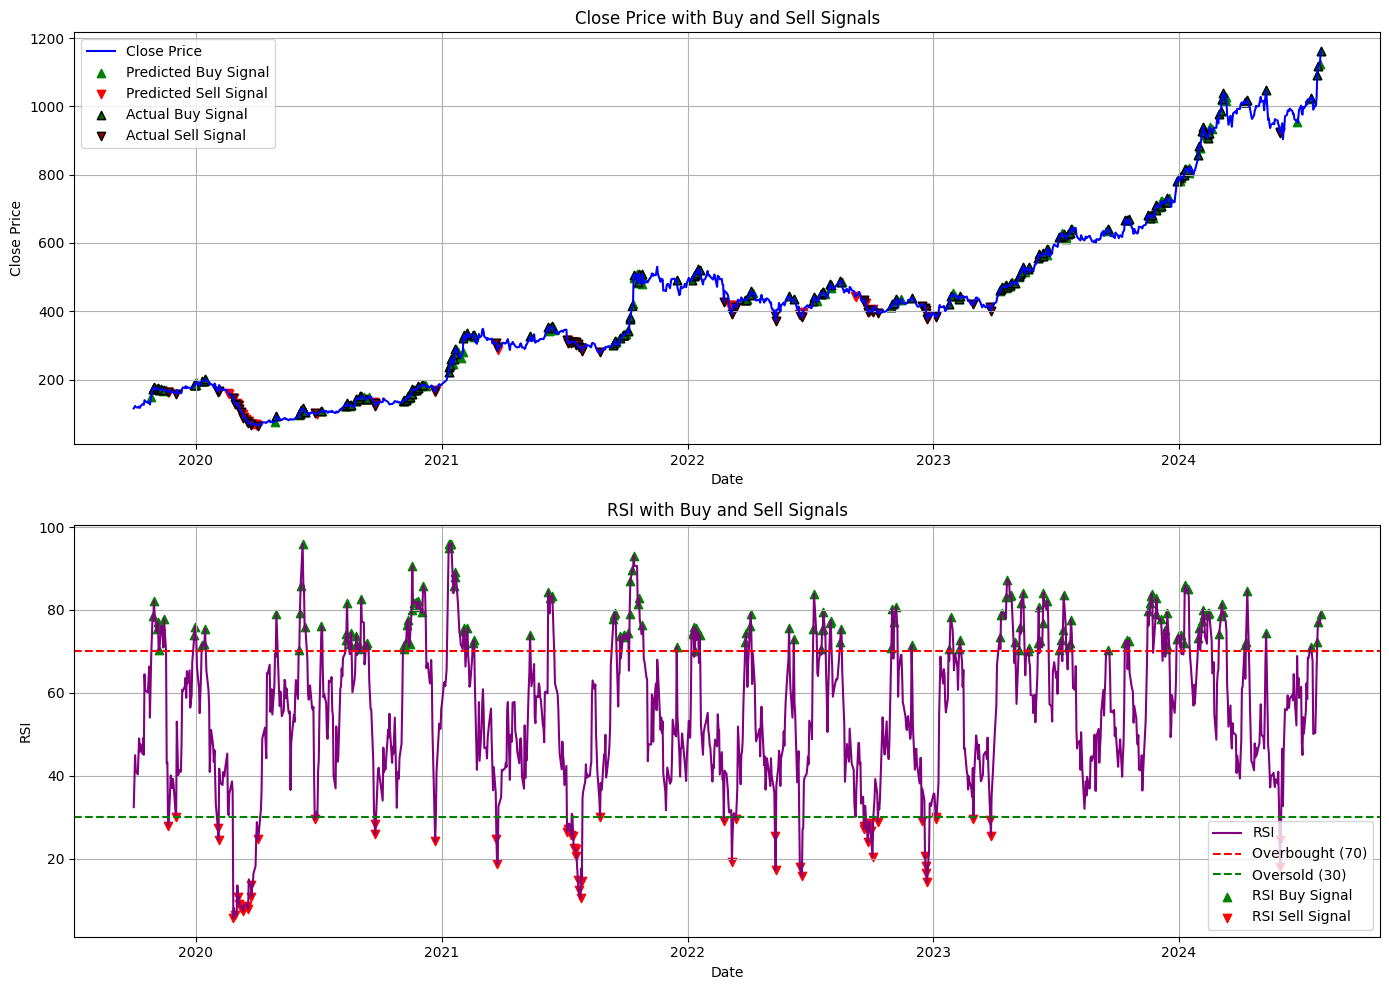

In [189]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.inspection import permutation_importance
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

def fetch_data(tickers, start, end):
    dfs = []
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end)
        df['Ticker'] = ticker
        df.reset_index(inplace=True)  # Ensure 'Date' is a column
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)  # Concatenate and reset index

def calculate_ema(df, column, period):
    df[f'EMA{period}'] = df[column].ewm(span=period, adjust=False).mean()
    return df

def calculate_macd(df):
    # Example MACD calculation; replace with actual logic
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    return df

def calculate_bollinger_bands(df, column):
    # Example Bollinger Bands calculation; replace with actual logic
    df['SMA20'] = df[column].rolling(window=20).mean()
    df['Bollinger High'] = df['SMA20'] + 2 * df[column].rolling(window=20).std()
    df['Bollinger Low'] = df['SMA20'] - 2 * df[column].rolling(window=20).std()
    return df

def calculate_vwap(df):
    # Example VWAP calculation; replace with actual logic
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
    return df

def calculate_rsi(df, column, period=14):
    # Calculate the price changes
    delta = df[column].diff()
    # Separate gains and losses
    gain = (delta.where(delta > 0, 0)).rolling(window=period, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=1).mean()
    # Calculate the RS (Relative Strength)
    rs = gain / loss
    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    # Add RSI to the DataFrame
    df['RSI'] = rsi
    return df

def apply_indicators(df):
    grouped = df.groupby('Ticker')

    def apply_group(group):
        group = group.sort_values(by='Date').drop_duplicates(subset=['Date'])
        group = calculate_ema(group, 'Close', 20)
        group = calculate_ema(group, 'Close', 50)
        group = calculate_ema(group, 'Close', 100)
        group = calculate_macd(group)
        group = calculate_bollinger_bands(group, 'Close')
        group = calculate_vwap(group)
        group = calculate_rsi(group, 'Close')
        return group

    result_df = grouped.apply(lambda x: apply_group(x)).reset_index(drop=True)
    return result_df

def create_labels(df):

    df['Buy'] = (df['RSI'] > 70) & (df['RSI'].diff() > 0)
    df['Sell'] = (df['RSI'] < 30) & (df['RSI'].diff() < 0)
    df['Label'] = np.where(df['Buy'], 1, np.where(df['Sell'], 2, 0))
    return df

def preprocess_data(df):
    df = create_labels(df)
    return df

def plot_signals(df):
    df['Date'] = pd.to_datetime(df['Date'])
    plt.figure(figsize=(14, 10))

    # Plot the close price
    plt.subplot(2, 1, 1)
    plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')

    # Plot predicted buy and sell signals
    if 'Predicted Label' in df.columns:
        buy_signals_pred = df[df['Predicted Label'] == 1]
        sell_signals_pred = df[df['Predicted Label'] == 2]
        plt.scatter(buy_signals_pred['Date'], buy_signals_pred['Close'], marker='^', color='g', label='Predicted Buy Signal', alpha=1)
        plt.scatter(sell_signals_pred['Date'], sell_signals_pred['Close'], marker='v', color='r', label='Predicted Sell Signal', alpha=1)

    # Plot actual buy and sell signals
    if 'Label' in df.columns:
        buy_signals_actual = df[df['Label'] == 1]
        sell_signals_actual = df[df['Label'] == 2]
        plt.scatter(buy_signals_actual['Date'], buy_signals_actual['Close'], marker='^', color='darkgreen', label='Actual Buy Signal', alpha=1, edgecolor='black')
        plt.scatter(sell_signals_actual['Date'], sell_signals_actual['Close'], marker='v', color='darkred', label='Actual Sell Signal', alpha=1, edgecolor='black')

    plt.title('Close Price with Buy and Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid()

    # Plot RSI
    plt.subplot(2, 1, 2)
    plt.plot(df['Date'], df['RSI'], label='RSI', color='purple')
    plt.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
    plt.axhline(y=30, color='g', linestyle='--', label='Oversold (30)')

    # Plot buy and sell signals based on RSI
    if 'Buy' in df.columns:
        buy_signals_rsi = df[df['Buy']]
        sell_signals_rsi = df[df['Sell']]
        plt.scatter(buy_signals_rsi['Date'], buy_signals_rsi['RSI'], marker='^', color='g', label='RSI Buy Signal', alpha=1)
        plt.scatter(sell_signals_rsi['Date'], sell_signals_rsi['RSI'], marker='v', color='r', label='RSI Sell Signal', alpha=1)

    plt.title('RSI with Buy and Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


# Define tickers and date range
new_tickers = ['TATAMOTORS.NS']
start_date = '2019-08-31'
end_date = '2024-07-31'

# Load the model and scaler
model = load_model('stock_prediction_model.h5')
scaler = joblib.load('scaler.save')  # Ensure scaler consistency

# Fetch and prepare data
df_new = fetch_data(new_tickers, start=start_date, end=end_date)
df_new = apply_indicators(df_new)
df_new.dropna(inplace=True) # Ensure no NaN values are in the DataFrame before prediction

# Create actual labels
df_new = preprocess_data(df_new)  # This should create the 'Label' column

# Prepare features for prediction
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA20', 'EMA50', 'EMA100', 'MACD', 'MACD Signal', 'Bollinger High', 'Bollinger Low', 'VWAP', 'RSI']
X_new = df_new[features]
X_new_scaled = scaler.transform(X_new)

# Make predictions
df_new['Predicted Label'] = np.argmax(model.predict(X_new_scaled), axis=1)

print("Columns after prediction:", df_new.columns)

# Now we can directly compare 'Label' (actual) with 'Predicted Label'
if 'Label' in df_new.columns and 'Predicted Label' in df_new.columns:
    print(classification_report(df_new['Label'], df_new['Predicted Label']))
else:
    print("Missing columns for comparison:")
    print("Label present:", 'Label' in df_new.columns)
    print("Predicted Label present:", 'Predicted Label' in df_new.columns)

# Define the custom scoring function
def custom_accuracy_scorer(y_true, y_pred):
    if len(y_pred.shape) > 1:
        y_pred = y_pred.argmax(axis=1)
    return accuracy_score(y_true, y_pred)

scorer = make_scorer(custom_accuracy_scorer, greater_is_better=True)

# Compute permutation importance
results = permutation_importance(
    estimator=model,  # The fitted model
    X=X_new_scaled,   # Scaled features
    y=df_new['Label'].values,  # Actual labels
    scoring=scorer  # Use the pre-defined scorer
)

# Print the feature importances
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA20', 'EMA50', 'EMA100', 'MACD', 'MACD Signal', 'Bollinger High', 'Bollinger Low', 'VWAP', 'RSI']
for i in results.importances_mean.argsort()[::-1]:
    print(f"Feature: {features[i]}, Importance: {results.importances_mean[i]:.4f}")

# Plot buy and sell signals
plot_signals(df_new)


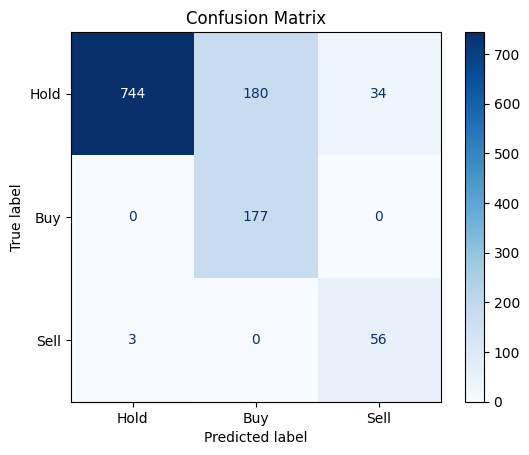

In [161]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
conf_matrix = confusion_matrix(df_new['Label'], df_new['Predicted Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Hold', 'Buy', 'Sell'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Shape of y_true: (122, 3)
Shape of y_scores: (122, 3)


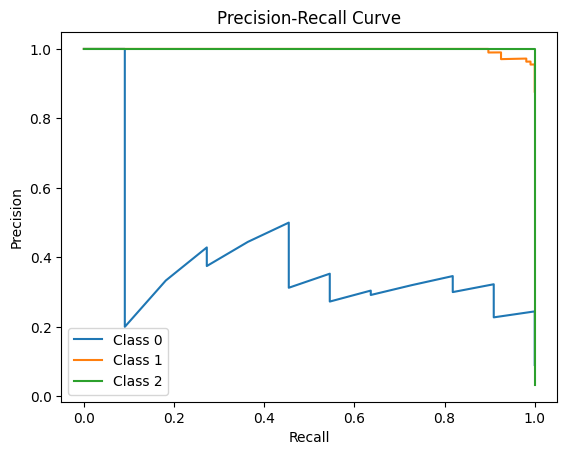

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Ensure `model` is properly trained and `X_new_scaled` is the correct input

# Binarize the labels for multi-class Precision-Recall
y_true = label_binarize(df_new['Label_Actual'], classes=[0, 1, 2])
y_scores = model.predict(X_new_scaled)  # Use `predict` instead of `predict_proba`

# Check shapes to ensure correctness
print(f"Shape of y_true: {y_true.shape}")
print(f"Shape of y_scores: {y_scores.shape}")

# Plot Precision-Recall curve for each class
for i in range(y_true.shape[1]):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_scores[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


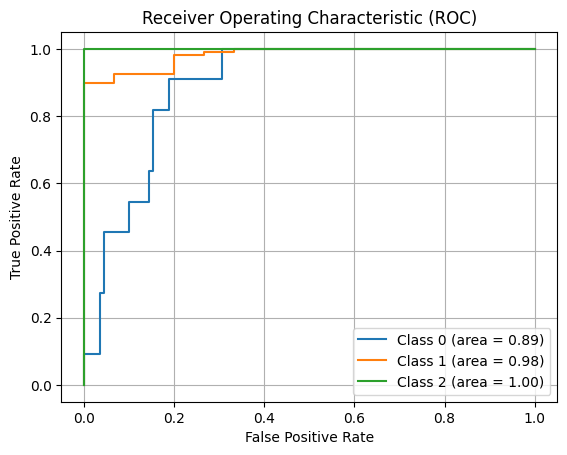

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC
y_true = label_binarize(df_new['Label_Actual'], classes=[0, 1, 2])
y_scores = model.predict(X_new_scaled)  # Use `predict` instead of `predict_proba`

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_true.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(y_true.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
!pip install shap
import shap

# Create a SHAP explainer
explainer = shap.KernelExplainer(model.predict, X_new_scaled)

# Compute SHAP values
shap_values = explainer.shap_values(X_new_scaled)

# Plot SHAP values for the first sample
shap.summary_plot(shap_values, X_new_scaled, feature_names=X_new.columns)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  0%|          | 0/122 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
7915/7915 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7915/7915 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
7915/7915 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
7915/7915 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
7915/7915 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
7915/7915 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7915/7915 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
7915/7915 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
7915/7915 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
7915/7915 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
 910/7915 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step

KeyboardInterrupt: 